In [3]:
import pandas as pd
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pmdarima as pm

os.getcwd()
os.chdir("C:\\Users\\User\\OneDrive\\Desktop\\Masters\\DS 745 Visualization and Unstructured Data Analysis\\\\Module 1\\Project 1 Forecasting and CLV")
os.getcwd()

'C:\\Users\\User\\OneDrive\\Desktop\\Masters\\DS 745 Visualization and Unstructured Data Analysis\\Module 1\\Project 1 Forecasting and CLV'

In [4]:
# Fill in missing months with 0's

import pandas as pd

all_df = pd.read_csv('all_sales_csv.csv')
all_df['sales_date'] = pd.to_datetime(all_df['sales_date'])

grouped_df = all_df.groupby([
    all_df['sales_date'].dt.to_period('M'),  # Groups by Year-Month
    'product'
])['sales_qty'].sum().reset_index()

# Convert sales_date to Period (Year-Month)
all_df['sales_date'] = all_df['sales_date'].dt.to_period('M')

# Group by Year-Month & Product, summing sales_qty
grouped_df = all_df.groupby(['sales_date', 'product'])['sales_qty'].sum().reset_index()

# Create a complete date range for all products
all_months = pd.period_range(start=grouped_df['sales_date'].min(), 
                             end=grouped_df['sales_date'].max(), 
                             freq='M')
all_products = grouped_df['product'].unique()

# Create a DataFrame with all combinations of (Month, Product)
full_index = pd.MultiIndex.from_product([all_months, all_products], 
                                        names=['sales_date', 'product'])
full_df = pd.DataFrame(index=full_index).reset_index()

# Merge with actual sales data
final_df = full_df.merge(grouped_df, on=['sales_date', 'product'], how='left')

# Fill missing sales_qty with 0
final_df['sales_qty'] = final_df['sales_qty'].fillna(0)


print(final_df.head(5))


  sales_date    product  sales_qty
0    1902-01  Product A       2610
1    1902-01  Product B      25273
2    1902-01  Product C       1002
3    1902-01  Product D       1943
4    1902-02  Product A       2467


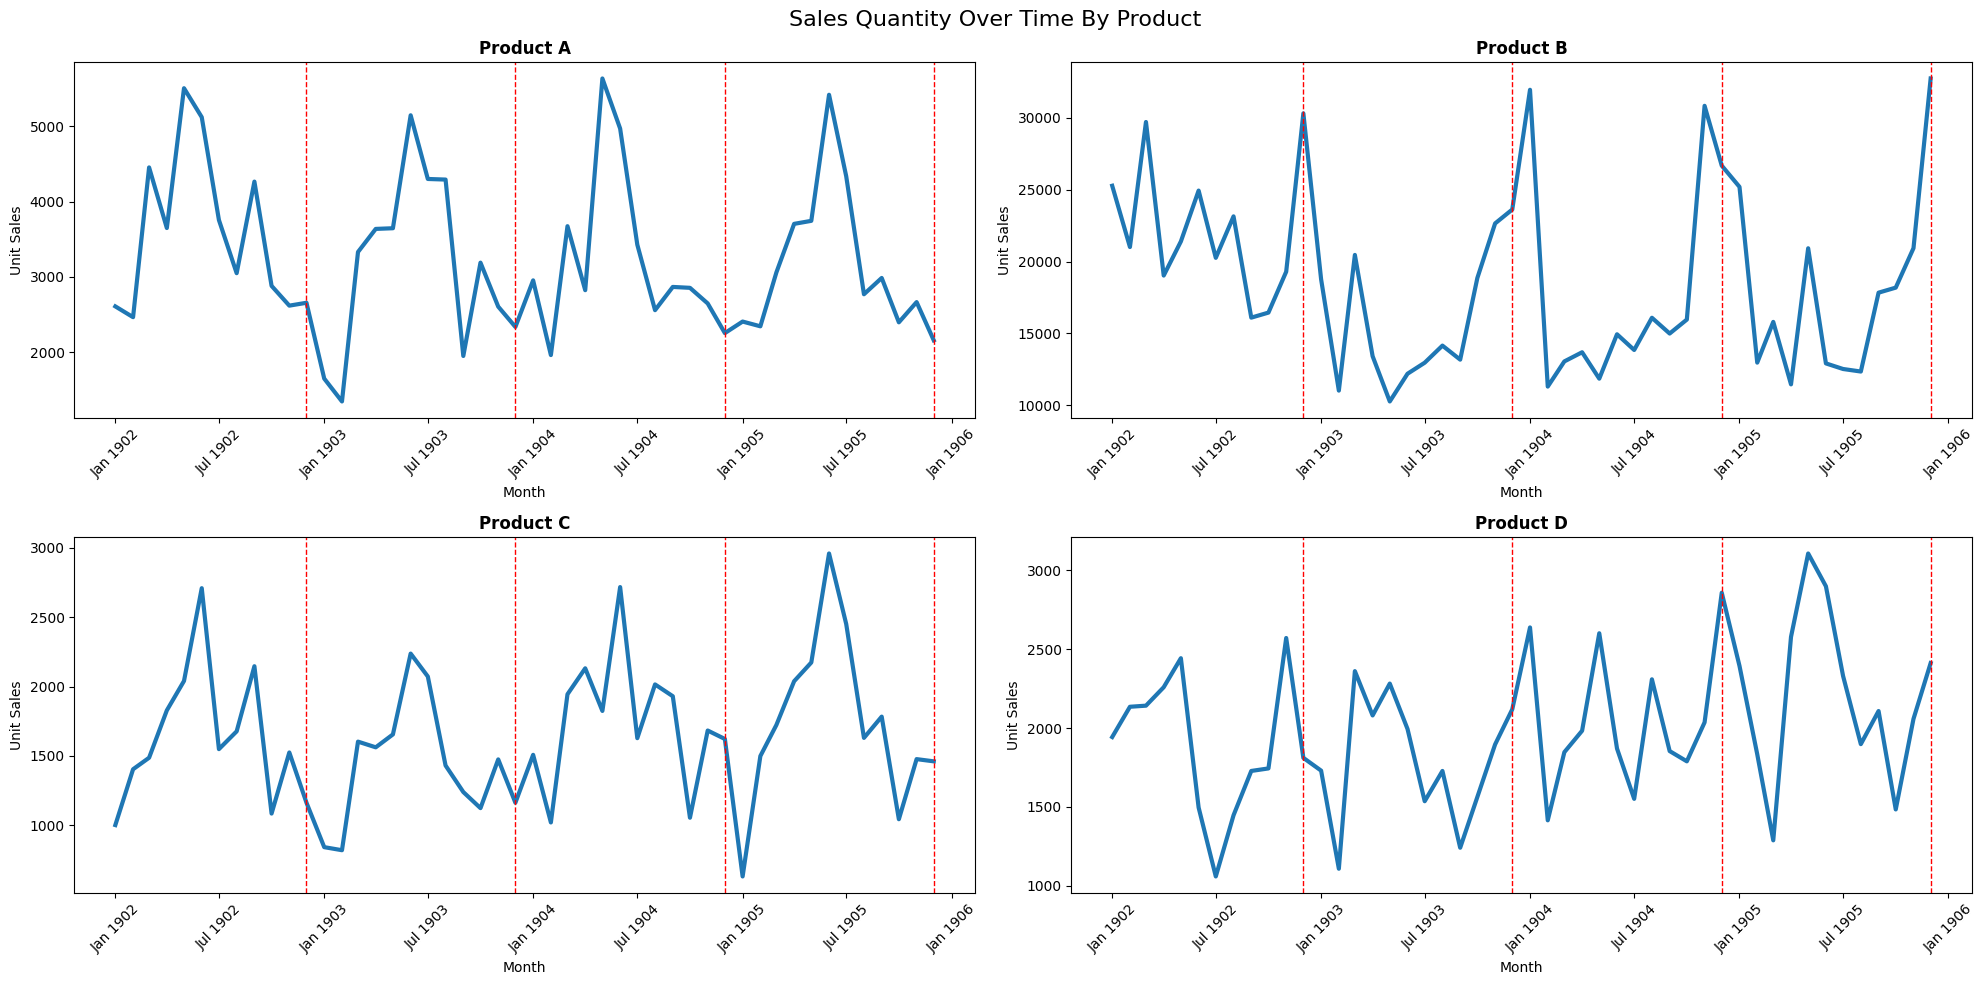

In [5]:
import pandas as pd


# Assuming you've already run the earlier steps to create final_df

# Get unique products
products = final_df['product'].unique()

# Create a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Flatten the axes array to make indexing easier
axs = axs.flatten()

# Plot each product on a separate subplot
for i, product in enumerate(products):
    # Filter data for the current product
    product_data = final_df[final_df['product'] == product]
    
    # Plot a bar graph of sales_qty over time
    axs[i].plot(product_data['sales_date'].dt.to_timestamp(), product_data['sales_qty'], label=product, linewidth = 3)
    
    # Set the title and labels
    fig.suptitle("Sales Quantity Over Time By Product", fontsize=16)  # Global title
    axs[i].set_title(f'{product}', fontsize = 12, fontweight = 'bold')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Unit Sales')
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Format the x-axis to show 'Month Year' (e.g., 'Jan 1904')
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Add vertical lines every 12 months (1 year)
    for j in range(1, len(product_data) // 12 + 1):
        axs[i].axvline(product_data['sales_date'].dt.to_timestamp().iloc[j * 12 - 1], color='r', linestyle='--', linewidth=1)

# Adjust the layout to avoid overlapping labels
plt.tight_layout()

# Save the plot to a file
plt.savefig('sales_qty.png')

# Show the plot
plt.show()


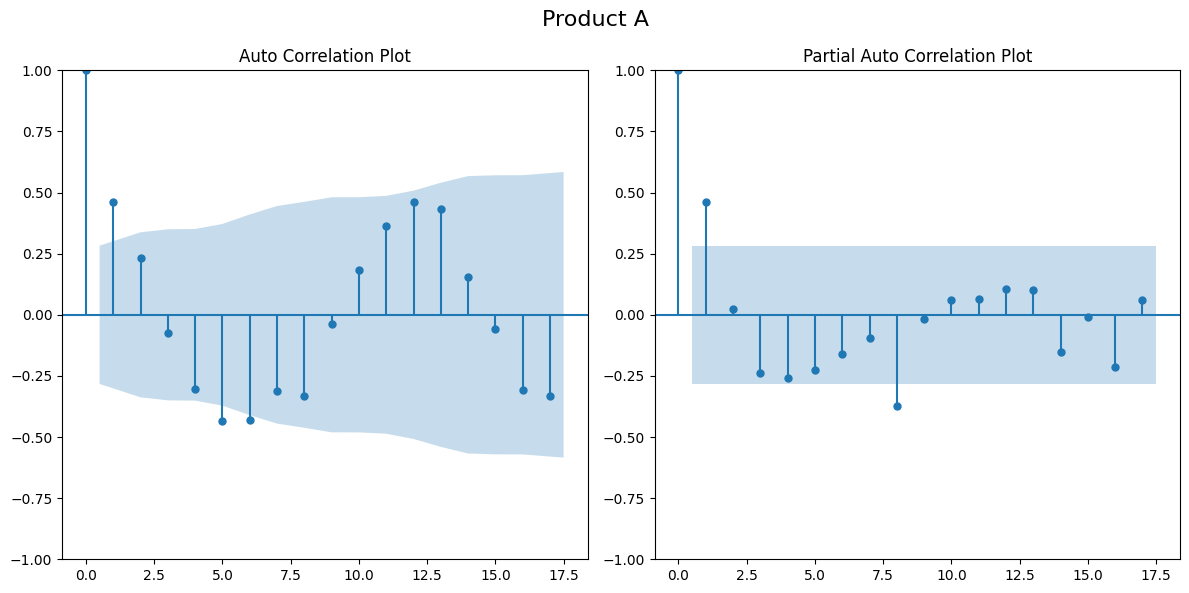

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Filter data only for Product A
product_A_data = final_df[final_df['product'] == 'Product A']

# Create a figure with two subplots (one for ACF, one for PACF)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# ACF Plot (Left)
plot_acf(product_A_data['sales_qty'], ax=axs[0])
axs[0].set_title('Auto Correlation Plot')

# PACF Plot (Right)
plot_pacf(product_A_data['sales_qty'], ax=axs[1])
axs[1].set_title('Partial Auto Correlation Plot')

# Adjust layout and save the figure
fig.suptitle("Product A", fontsize=16)  # Global title

plt.tight_layout()
#plt.savefig('acf_pacf_product_A.png')

plt.show()


In [8]:

# Dictionary to store results
arima_results = []

# Dictionary to store the best fitted models for each product
best_fitted_models = {}

products = final_df['product'].unique()

for product in products:
    df = final_df[final_df['product'] == product].reset_index()
    #print(df)
        # Split into train and test by product
    msk = (df.index < len(df) - 6)
    df_train = df[msk].copy()
    df_test = df[~msk].copy()
   # print(df_test.head())
   # print(df.shape)
    
   # Train Auto-ARIMA with different seasonal values
    best_model = None
    best_aic = float("inf")  # Initialize with a very high AIC

    for m in [0, 6, 12]:  # Iterate over different seasonal periods
        try:
            # Train Auto-ARIMA with different seasonal values
            auto_arima_model = pm.auto_arima(
                df_train['sales_qty'],
                stepwise=True,
                seasonal=True if m > 0 else False,  # Seasonal only if m > 0
                trace=True,
                m=m)

            # Extract parameters
            order = auto_arima_model.order  # (p, d, q)
            seasonal_order = auto_arima_model.seasonal_order  # (P, D, Q, s)

            # Store the best model based on AIC
            if auto_arima_model.aic() < best_aic:
                best_aic = auto_arima_model.aic()
                best_model = auto_arima_model

            # Append results
            arima_results.append({
                'Product': product,
                'p': int(order[0]),
                'd': int(order[1]),
                'q': int(order[2]),
                'P': int(seasonal_order[0]) if m > 0 else None,
                'D': int(seasonal_order[1]) if m > 0 else None,
                'Q': int(seasonal_order[2]) if m > 0 else None,
                's': int(seasonal_order[3]) if m > 0 else None,
                'AIC': round(auto_arima_model.aic(), 2)
            })
        except Exception as e:
            print(f"Error fitting ARIMA for Product {product} with m={m}: {e}")

    # Store the best model for the product
    if best_model:
        best_fitted_models[f"best_fit_{product}"] = best_model




Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=715.785, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=806.556, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=713.441, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=772.695, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=711.902, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=713.766, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=713.768, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=712.401, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=715.764, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=703.508, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=701.633, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=708.947, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=703.592, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=704.356, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=705.1

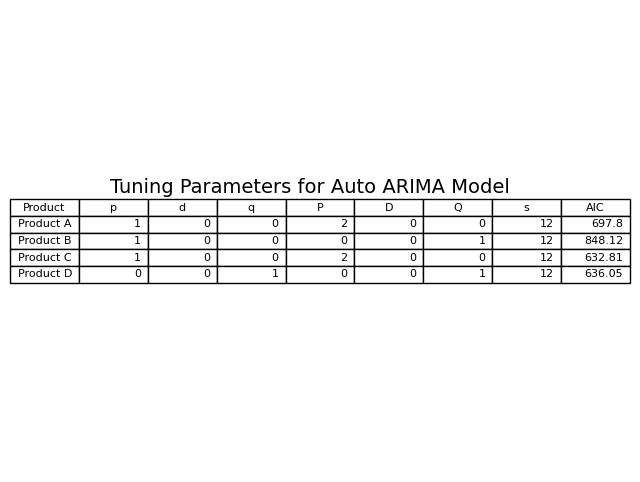

In [9]:
# Convert to DataFrame for easy display
arima_df = pd.DataFrame(arima_results)


# Select only the row with the minimum AIC for each product
best_arima_df = arima_df.loc[arima_df.groupby("Product")["AIC"].idxmin()]

best_arima_df['D'] = best_arima_df['D'].round(0).astype('int')
best_arima_df['P'] = best_arima_df['P'].round(0).astype('int')
best_arima_df['Q'] = best_arima_df['Q'].round(0).astype('int')
best_arima_df['s'] = best_arima_df['s'].round(0).astype('int')

# Format the table using tabulate for better readability
table_string = tabulate(best_arima_df, headers='keys', tablefmt='fancy_grid', showindex=False)

#print(table_string)
# Create a figure and add the table as an image
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size as necessary
ax.axis('tight')
fig.suptitle('Tuning Parameters for Auto ARIMA Model', fontsize=14, y=0.6) 
ax.axis('off')
ax.table(cellText=best_arima_df.values, colLabels=best_arima_df.columns, loc='center')

# Save the table as a PNG image
plt.savefig("table.png", format="png", bbox_inches="tight")

# Show the plot (optional)
plt.show()


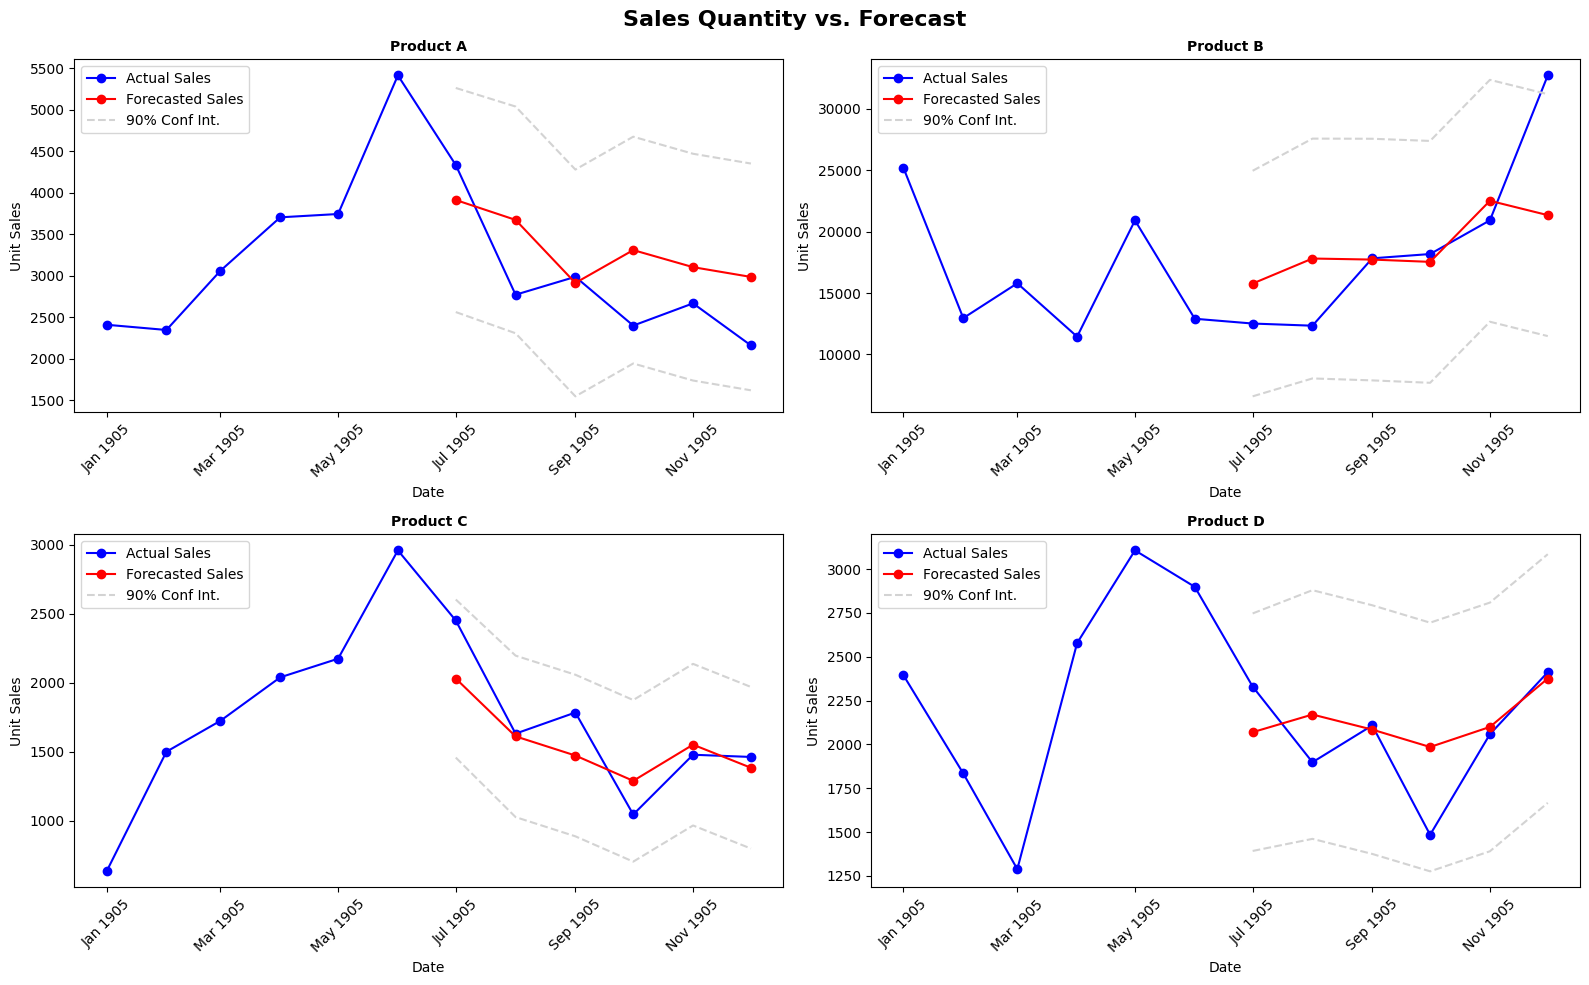

In [38]:
import pandas as pd


fig, axs = plt.subplots(2, 2, figsize=(16, 10))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten for easier indexing

plt.subplots_adjust(hspace=1, wspace=1)  # Increase space between subplots

for i, product in enumerate(final_df['product'].unique()):
    product_data = final_df[final_df['product'] == product].reset_index()
    #print(product_data.shape)
    #split into test / train
    msk = (product_data.index < len(product_data)-6)
    df_train = product_data[msk].copy()
    df_test = product_data[~msk].copy()
    
    # Get best model for the product
    best_model = best_fitted_models.get(f"best_fit_{product}")
    
    # Perform prediction with confidence intervals
    forecast_test, conf_int = best_model.predict(len(df_test), return_conf_int=True, alpha=0.10)

    # Extract upper and lower bounds
    ci_lower = conf_int[:, 0]
    ci_upper = conf_int[:, 1]


    product_data['forecast_auto'] = [None]*len(df_train) + list(forecast_test)
    product_data['ci_lower'] = [None]*len(df_train) + list(ci_lower)
    product_data['ci_upper'] = [None]*len(df_train) + list(ci_upper)
    product_data = product_data[product_data['sales_date'].dt.year > 1904]
    #print(product_data)


    
    
    #print(product_data.tail())
    #print(product_data.dtypes)
    

    
# Plot sales_qty and forecast_auto on the same axes
    axs[i].plot(product_data['sales_date'].dt.to_timestamp(), product_data['sales_qty'], label="Actual Sales", marker="o", color="blue")
    axs[i].plot(product_data['sales_date'].dt.to_timestamp(), product_data['forecast_auto'], label="Forecasted Sales", marker="o", color="red")
    
    axs[i].plot(product_data['sales_date'].dt.to_timestamp(), product_data['ci_lower'], label="90% Conf Int.", color="lightgray", linestyle='--')
    axs[i].plot(product_data['sales_date'].dt.to_timestamp(), product_data['ci_upper'], color="lightgray", linestyle='--')
    
    # Set the title and labels
    fig.suptitle("Sales Quantity vs. Forecast", fontsize=16,fontweight = 'bold')  # Global title

    axs[i].set_title(f"{product}", fontsize=10, fontweight = 'bold')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Unit Sales')
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    axs[i].legend(loc='upper left')
    
    # Format the x-axis to show 'Month Year' (e.g., 'Jan 1904')
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('sales_vs_forecast2_.png')
plt.show()
    
    
    
    
    

    
    

In [659]:
import lifetimes

all_df = pd.read_csv('all_sales_csv.csv')
all_df['sales_date'] = pd.to_datetime(all_df['sales_date'])

prod_a = all_df[all_df['product'] == 'Product A']
prod_a.dtypes

summary = lifetimes.utils.summary_data_from_transaction_data(prod_a,'customer','sales_date','sales_qty')
summary = summary.reset_index()
summary.head(20)

,customer,frequency,recency,T,monetary_value
0,Customer 101,0.0,0.0,0.0,0.000000
1,Customer 102,29.0,1322.0,1322.0,85.448276
2,Customer 103,84.0,1435.0,1435.0,84.428571
3,Customer 104,34.0,1387.0,1398.0,13.088235
4,Customer 105,16.0,1406.0,1419.0,12.500000
5,Customer 106,54.0,1184.0,1189.0,44.425926
6,Customer 107,117.0,1449.0,1454.0,93.811966
7,Customer 108,34.0,1393.0,1408.0,9.117647
8,Customer 109,59.0,1035.0,1035.0,115.525424
9,Customer 110,43.0,1374.0,1392.0,41.860465


<Axes: ylabel='Frequency'>

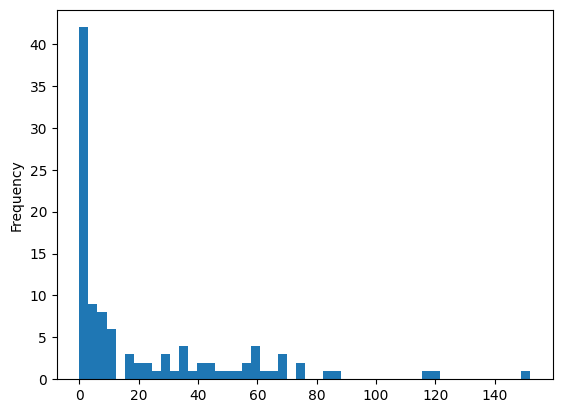

In [660]:
summary['frequency'].plot(kind = 'hist', bins = 50)

In [661]:
bgf = lifetimes.BetaGeoFitter(penalizer_coef = 0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.404927,0.057313,0.292594,0.517260
alpha,16.316981,3.495741,9.465328,23.168634
a,0.160658,0.080732,0.002422,0.318893
b,4.745474,4.681852,-4.430956,13.921904


In [662]:
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary.head()

,customer,frequency,recency,T,monetary_value,probability_alive
0,Customer 101,0.0,0.0,0.0,0.000000,1.000000
1,Customer 102,29.0,1322.0,1322.0,85.448276,0.995118
2,Customer 103,84.0,1435.0,1435.0,84.428571,0.998172
3,Customer 104,34.0,1387.0,1398.0,13.088235,0.994463
4,Customer 105,16.0,1406.0,1419.0,12.500000,0.990642


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

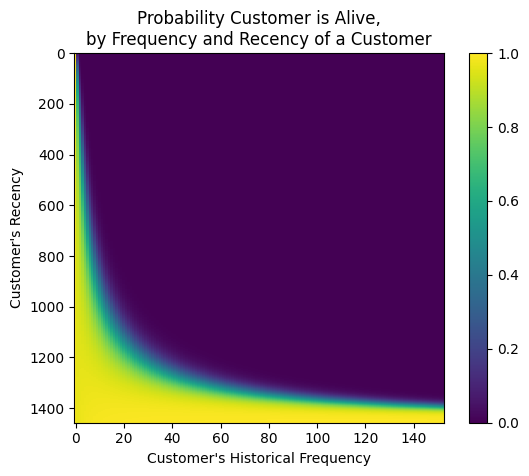

In [538]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure()
plot_probability_alive_matrix(bgf)

In [667]:
t = 365
summary['pred_num_transactions'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                                 summary['frequency'],
                                                                                                 summary['recency'],
                                                                                                 summary['T']),2)
summary.sort_values(by='customer', ascending = True).head(20).reset_index()
                                                                       

,index,customer,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions,Pred. Total Purchases (CLV)
0,0,Customer 101,0.0,0.0,0.0,0.000000,1.000000,7.52,1079.321840
1,1,Customer 102,29.0,1322.0,1322.0,85.448276,0.995118,7.84,661.100003
2,2,Customer 103,84.0,1435.0,1435.0,84.428571,0.998172,20.81,1733.860312
3,3,Customer 104,34.0,1387.0,1398.0,13.088235,0.994463,8.68,113.023510
4,4,Customer 105,16.0,1406.0,1419.0,12.500000,0.990642,4.07,51.149196
5,5,Customer 106,54.0,1184.0,1189.0,44.425926,0.996524,16.08,705.574591
6,6,Customer 107,117.0,1449.0,1454.0,93.811966,0.998019,28.57,2644.537186
7,7,Customer 108,34.0,1393.0,1408.0,9.117647,0.993911,8.61,78.475748
8,8,Customer 109,59.0,1035.0,1035.0,115.525424,0.997446,20.09,2289.883366
9,9,Customer 110,43.0,1374.0,1392.0,41.860465,0.994029,10.98,454.388424


In [677]:
return_customers_summary = summary[summary['frequency'] > 0]
print(return_customers_summary.shape)
return_customers_summary[['frequency','monetary_value']].corr()

(82, 8)


,frequency,monetary_value
frequency,1.000000,0.412551
monetary_value,0.412551,1.000000


In [541]:
return_customers_summary['purchase_total_over_time'] = return_customers_summary['monetary_value'] * return_customers_summary['pred_num_transactions']




prob_alive = return_customers_summary[(return_customers_summary['probability_alive'] < .9) & 
                                                                (return_customers_summary['purchase_total_over_time'] > 50)]

return_customers_summary.sort_values(by= 'purchase_total_over_time', ascending = False).head(10).reset_index()

prob_alive.sort_values(by= 'probability_alive', ascending = True).head(10)


,customer,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions,purchase_total_over_time
64,Customer 165,4.0,191.0,674.0,216.000000,0.194175,0.44,95.040000
47,Customer 148,69.0,1339.0,1442.0,87.188406,0.737245,12.58,1096.830145


In [669]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.001)
ggf.fit(return_customers_summary['frequency'], 
        return_customers_summary['monetary_value'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,4.543687,1.256912,2.080139,7.007234
q,1.135197,0.160333,0.820943,1.449450
v,4.326073,1.287986,1.801620,6.850526


In [678]:
#summary = summary[summary['monetary_value'] > 0]
summary['exp_avg_qty'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                                                 summary['monetary_value'])
summary.head()

,customer,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions,Pred. Total Purchases (CLV),exp_avg_qty
0,Customer 101,0.0,0.0,0.0,0.000000,1.000000,7.52,1079.321840,145.390650
1,Customer 102,29.0,1322.0,1322.0,85.448276,0.995118,7.84,661.100003,85.509715
2,Customer 103,84.0,1435.0,1435.0,84.428571,0.998172,20.81,1733.860312,84.450158
3,Customer 104,34.0,1387.0,1398.0,13.088235,0.994463,8.68,113.023510,13.203917
4,Customer 105,16.0,1406.0,1419.0,12.500000,0.990642,4.07,51.149196,12.746675


In [679]:
summary['Pred. Total Purchases (CLV)'] = ggf.customer_lifetime_value(bgf,
                                                       summary['frequency'],
                                                       summary['recency'],
                                                       summary['T'],
                                                       summary['monetary_value'],
                                                       time = 12,
                                                       freq = 'D',
                                                       discount_rate = 0.00)

summary[summary['customer'] == 'Customer 148']

,customer,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions,Pred. Total Purchases (CLV),exp_avg_qty
47,Customer 148,69.0,1339.0,1442.0,87.188406,0.737245,12.58,1082.505567,87.213493


['Customer', 'Frequency', 'Recency', 'T', 'Churn Probability', 'Expected No. of Purchases', 'Pred. Total Purchases (CLV)', 'Expected Avg. Purchase Qty']


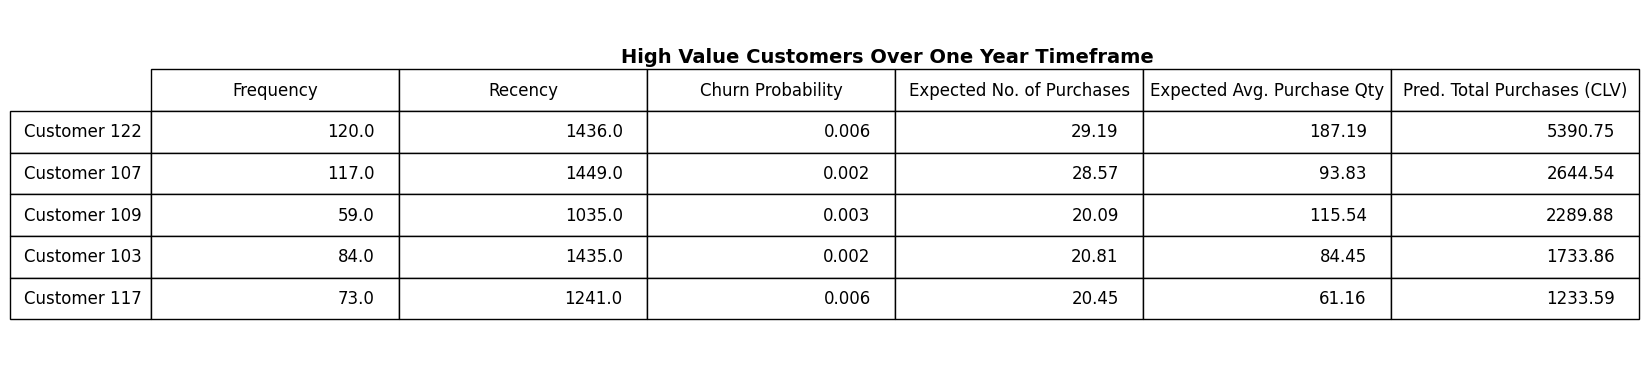

In [683]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import numpy as np
import textwrap

high_value = summary.drop(['monetary_value'], axis=1)

high_value = high_value.rename({'customer': 'Customer', 
                                'frequency': 'Frequency',
                                'recency': 'Recency',
                                'probability_alive': 'Churn Probability',
                                'pred_num_transactions': 'Expected No. of Purchases',
                                'exp_avg_qty': 'Expected Avg. Purchase Qty',
                               }, axis=1)
print(high_value.columns.tolist())  # Check exact column names

high_value['Pred. Total Purchases (CLV)'] = round(high_value['Pred. Total Purchases (CLV)'],2)
high_value['Churn Probability'] = 1 - high_value['Churn Probability']
high_value['Churn Probability'] = high_value['Churn Probability'].round(3)
high_value['Expected Avg. Purchase Qty'] = round(high_value['Expected Avg. Purchase Qty'],2)

high_value = high_value[['Customer','Frequency','Recency','Churn Probability','Expected No. of Purchases',
                         'Expected Avg. Purchase Qty','Pred. Total Purchases (CLV)']]
high_value = high_value.sort_values(by = 'Pred. Total Purchases (CLV)', ascending = False)

high_value = high_value[(high_value['Churn Probability'] < .01)]
high_value = high_value.head(5)

# Format the table using tabulate for better readability
table_string = tabulate(high_value, headers='keys', tablefmt='fancy_grid', showindex=False)

high_value = high_value.set_index("Customer")

#print(table_string)
# Create a figure and add the table as an image
fig, ax = plt.subplots() # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.axis('tight')
fig.suptitle('High Value Customers Over One Year Timeframe', fontsize=14, y=.8,fontweight= 'bold') 
ax.set_frame_on(False)
tabla = table(ax,high_value, loc='center', colWidths=[1] * len(high_value.columns))
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
tabla.scale(.5, 2.5)

# Save the table as a PNG image
plt.savefig("high_value.png", format="png", bbox_inches="tight")

# Show the plot (optional)
plt.show()



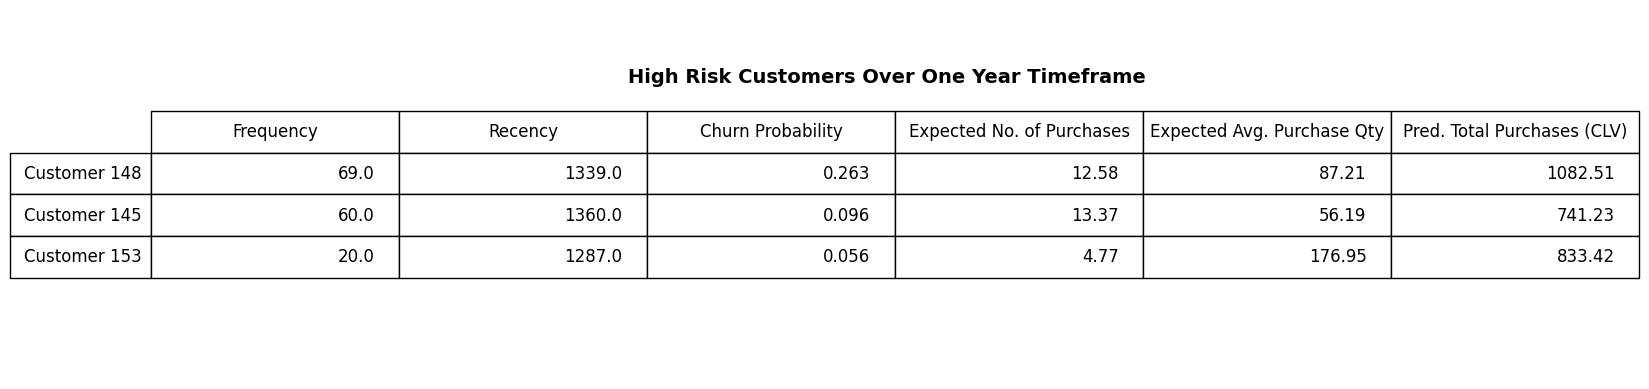

In [686]:
high_risk = summary.drop(['monetary_value'], axis=1)

high_risk = high_risk.rename({'customer': 'Customer', 
                                'frequency': 'Frequency',
                                'recency': 'Recency',
                                'probability_alive': 'Churn Probability',
                                'pred_num_transactions': 'Expected No. of Purchases',
                                'exp_avg_qty': 'Expected Avg. Purchase Qty',
                               }, axis=1)


high_risk['Pred. Total Purchases (CLV)'] = round(high_risk['Pred. Total Purchases (CLV)'],2)
high_risk['Churn Probability'] = 1 - high_risk['Churn Probability']
high_risk['Churn Probability'] = high_risk['Churn Probability'].round(3)

high_risk['Expected Avg. Purchase Qty'] = high_risk['Expected Avg. Purchase Qty'].round(2)

high_risk = high_risk[(high_risk['Pred. Total Purchases (CLV)'] > 200) & 
                      (high_risk['Churn Probability'] > .05)]

high_risk = high_risk[['Customer','Frequency','Recency','Churn Probability','Expected No. of Purchases',
                         'Expected Avg. Purchase Qty','Pred. Total Purchases (CLV)']]

high_risk = high_risk.sort_values(by = 'Churn Probability', ascending = False)

# Format the table using tabulate for better readability
table_string = tabulate(high_risk, headers='keys', tablefmt='fancy_grid', showindex=False)

high_risk = high_risk.set_index("Customer")

#high_value.columns = ['\n'.join(textwrap.wrap(col, width=10)) for col in high_value.columns]

#print(table_string)
# Create a figure and add the table as an image
fig, ax = plt.subplots() # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
fig.suptitle('High Risk Customers Over One Year Timeframe', fontsize=14, y=.76,fontweight= 'bold') 
ax.set_frame_on(False)
tabla = table(ax,high_risk, loc='center', colWidths=[1] * len(high_risk.columns))
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
tabla.scale(.5, 2.5)

# Save the table as a PNG image
#plt.savefig("high_risk.png", format="png", bbox_inches="tight")

# Show the plot (optional)
plt.show()

